In [1]:
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

plt.style.use('Joey')


import numpy as np
import pandas as pd
import scipy.stats as sps

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d

from os.path import join

from tqdm import tqdm

In [2]:
import mossbauer
from mossbauer.utils import *

In [3]:
def change_axis_color(ax, color, x_or_y='y'):
    getattr(ax, x_or_y + 'axis').label.set_color(color)
    ax.tick_params(axis=x_or_y, colors=color)
    
    ax.spines[
        dict(y='right', x='top')[x_or_y]
    ].set_color(color)
    return

In [4]:
pos = np.array([-5.48, -3.25, -1.01, 0.66, 2.90, 5.13])  # from Violet and Pipcorn 1971
pos = pos - np.mean(pos)
split_ratio = (3, 2, 1, 1, 2, 3)
#spacing = 8./5  # from fultz 2012
offset = 0.0# -0.1209  # ritverc Rh source
#leftmost_res = -2.5*spacing + offset
#Eres = np.arange(leftmost_res, leftmost_res + (len(split_ratio)*spacing), spacing)
Eres = pos + offset

In [5]:
natural_linewidth = 4.55e-9  # eV
source_activity = 3.7e10 * 1e-3  # Hz
mossbauer_relative_intensity = 0.0916

### source parameters
source_parameters = dict(
    Eres=Eres,
    transition_coefficients=np.asarray(split_ratio, dtype=float)/np.sum(split_ratio),
    linewidth=E_to_vel(natural_linewidth),
    total_activity=mossbauer_relative_intensity * source_activity
)

### absorber parameters
absorption_coefficient = 25.0  # cm^2 / mgFe57  (doublecheck)
recoilless_fraction_A = 0.8
t_mgcm2 = 0.13  # potassium ferrocyanide from ritverc
t_micron = 10. # micron
iron_density = 7.87  # g/cm3
natural_abundance = 0.02
t_mgcm2 = (t_micron / 1e4) * iron_density * 1e3 * natural_abundance
print(t_mgcm2, t_mgcm2/natural_abundance)
thickness_normalized = t_mgcm2 * absorption_coefficient * recoilless_fraction_A
print(thickness_normalized)
#thickness_normalized = 3.15#0.01


absorber_parameters = dict(
    Eres=Eres,
    transition_coefficients=np.asarray(split_ratio, dtype=float)/np.sum(split_ratio),
    linewidth=E_to_vel(natural_linewidth),
    thickness_normalized=thickness_normalized
)

### measurement parameters
detector_face_OD = 2 * 25.4  # mm
detector_distance = 22*25.4  # mm
measurement_parameters = dict(
    acquisition_time=3600.*24*31,
    solid_angle_fraction=(detector_face_OD**2)/(16*detector_distance**2),
    detection_efficiency = 1
)

0.1574 7.87
3.1480000000000006


In [6]:
moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters,
)

In [7]:
moss.transmitted_spectrum(100.0)

1750.6185794972157

In [8]:
### source parameters
source_parameters = dict(
    Eres=0.0,
    #transition_coefficients=np.asarray(split_ratio, dtype=float)/np.sum(split_ratio),
    linewidth=E_to_vel(natural_linewidth),
    total_activity=mossbauer_relative_intensity * source_activity
)
moss_unsplit_source = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters,
)


absorber_parameters = dict(
    Eres=0.0,
    transition_coefficients=np.asarray(split_ratio, dtype=float)/np.sum(split_ratio),
    linewidth=E_to_vel(natural_linewidth),
    thickness_normalized=thickness_normalized
)

moss_unsplit_source_unsplit_absorber = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters,
)

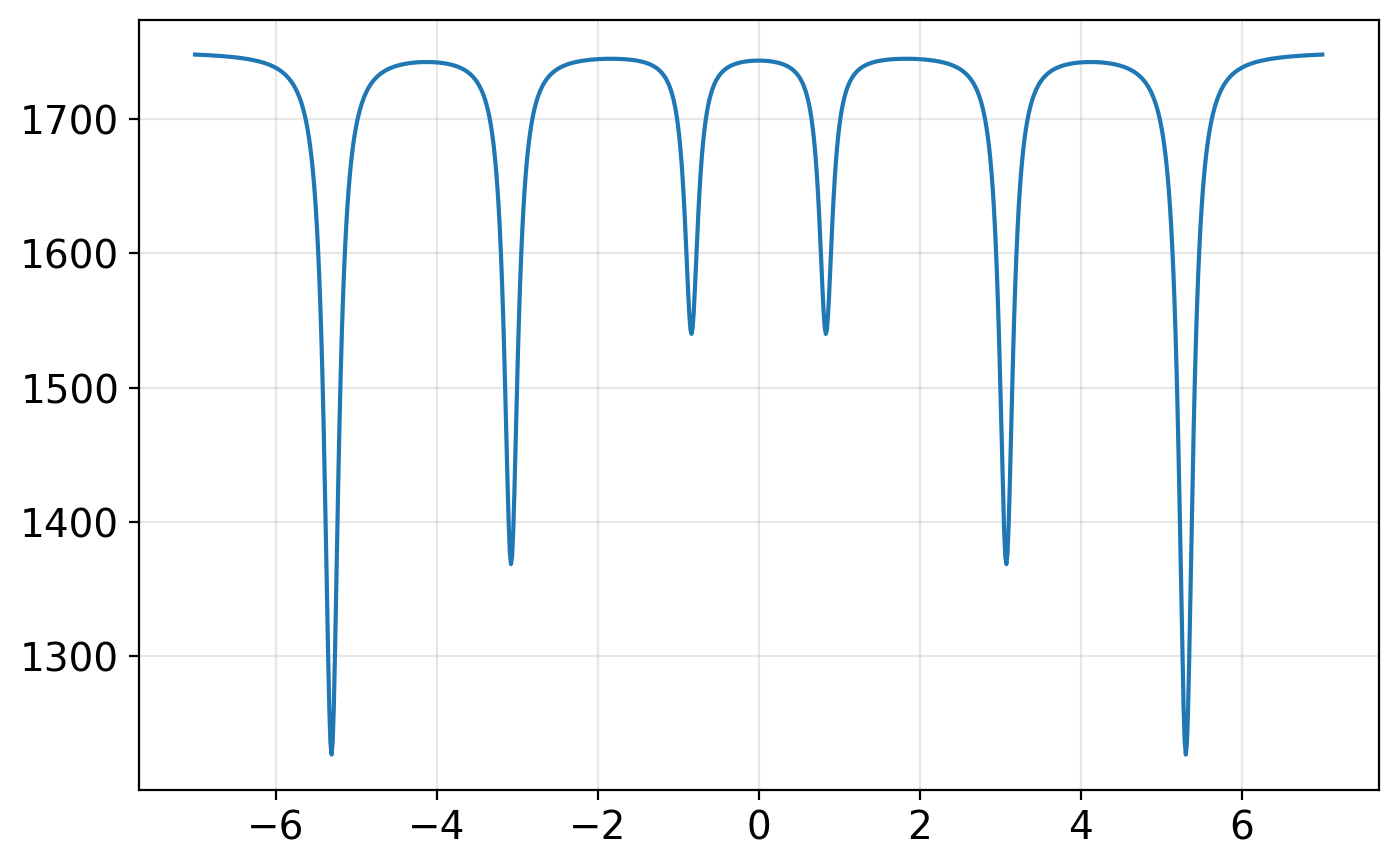

In [9]:
vel = np.linspace(-7, 7, 1000)
a1 = moss_unsplit_source.transmitted_spectrum(vel)
a2 = moss.transmitted_spectrum(vel)
a3 = moss_unsplit_source_unsplit_absorber.transmitted_spectrum(vel)
plt.plot(vel, a1, label='Single-Line Source (Rh Substrate)')
#

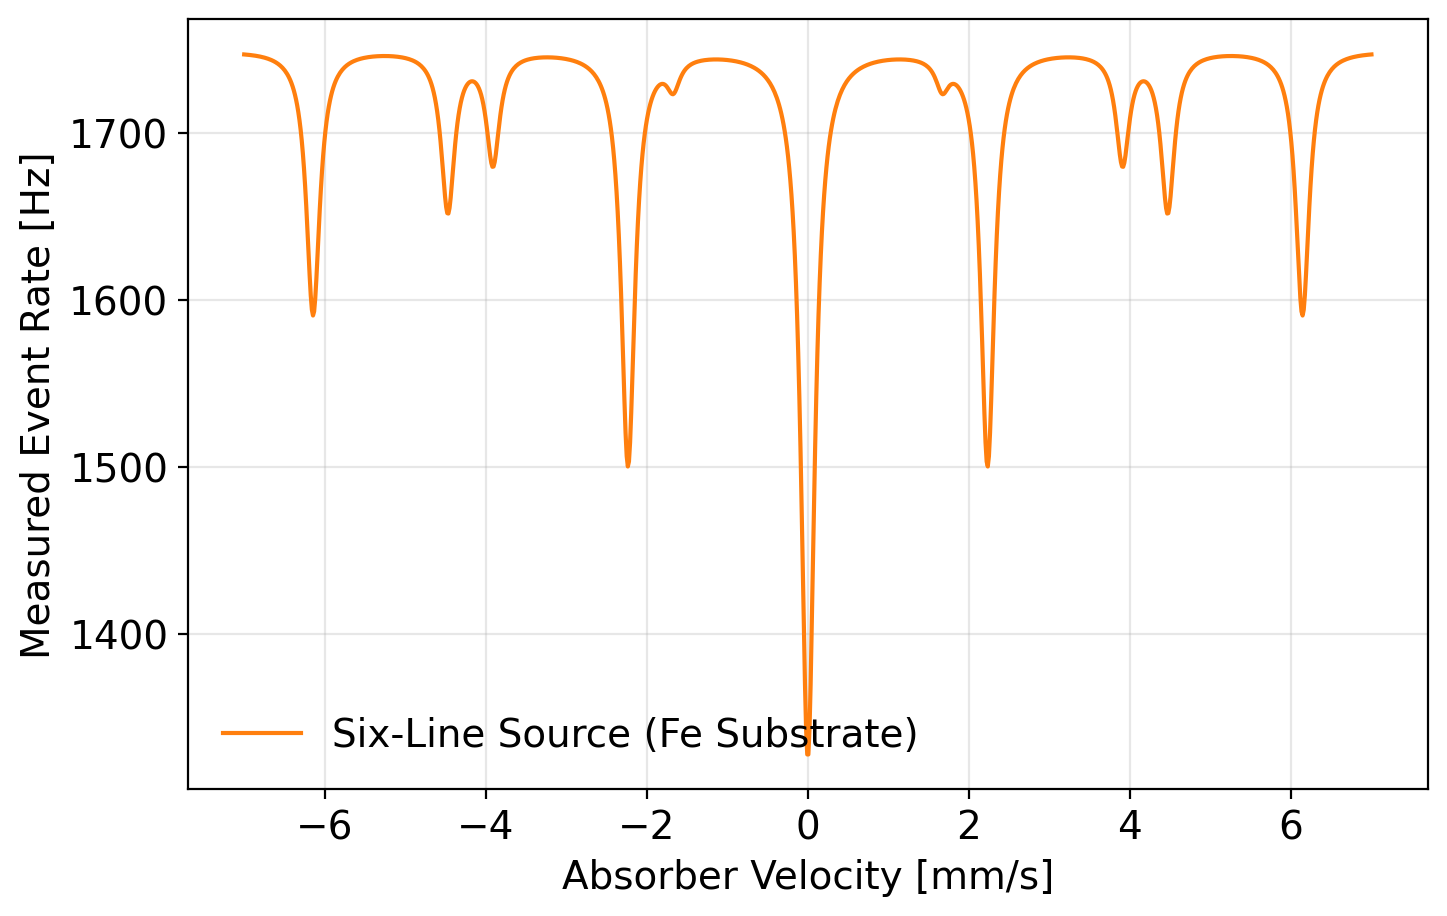

1.70e+06
1.71e+06
1.72e+06


In [13]:
plt.plot(vel, a2, label='Six-Line Source (Fe Substrate)', color = 'C1')
#plt.plot(vel, a3, label='Unsplit Unsplit')
plt.legend(loc=0)
plt.xlabel('Absorber Velocity [mm/s]')
plt.ylabel('Measured Event Rate [Hz]')

#if True:
#    plt.savefig('plots/source_splitting_absorption_overlay.png')

plt.show()
_ = [print('%.2e' % np.sum(a)) for a in [a1, a2, a3]]

In [107]:
E_to_vel(natural_linewidth)

0.09479166666666666

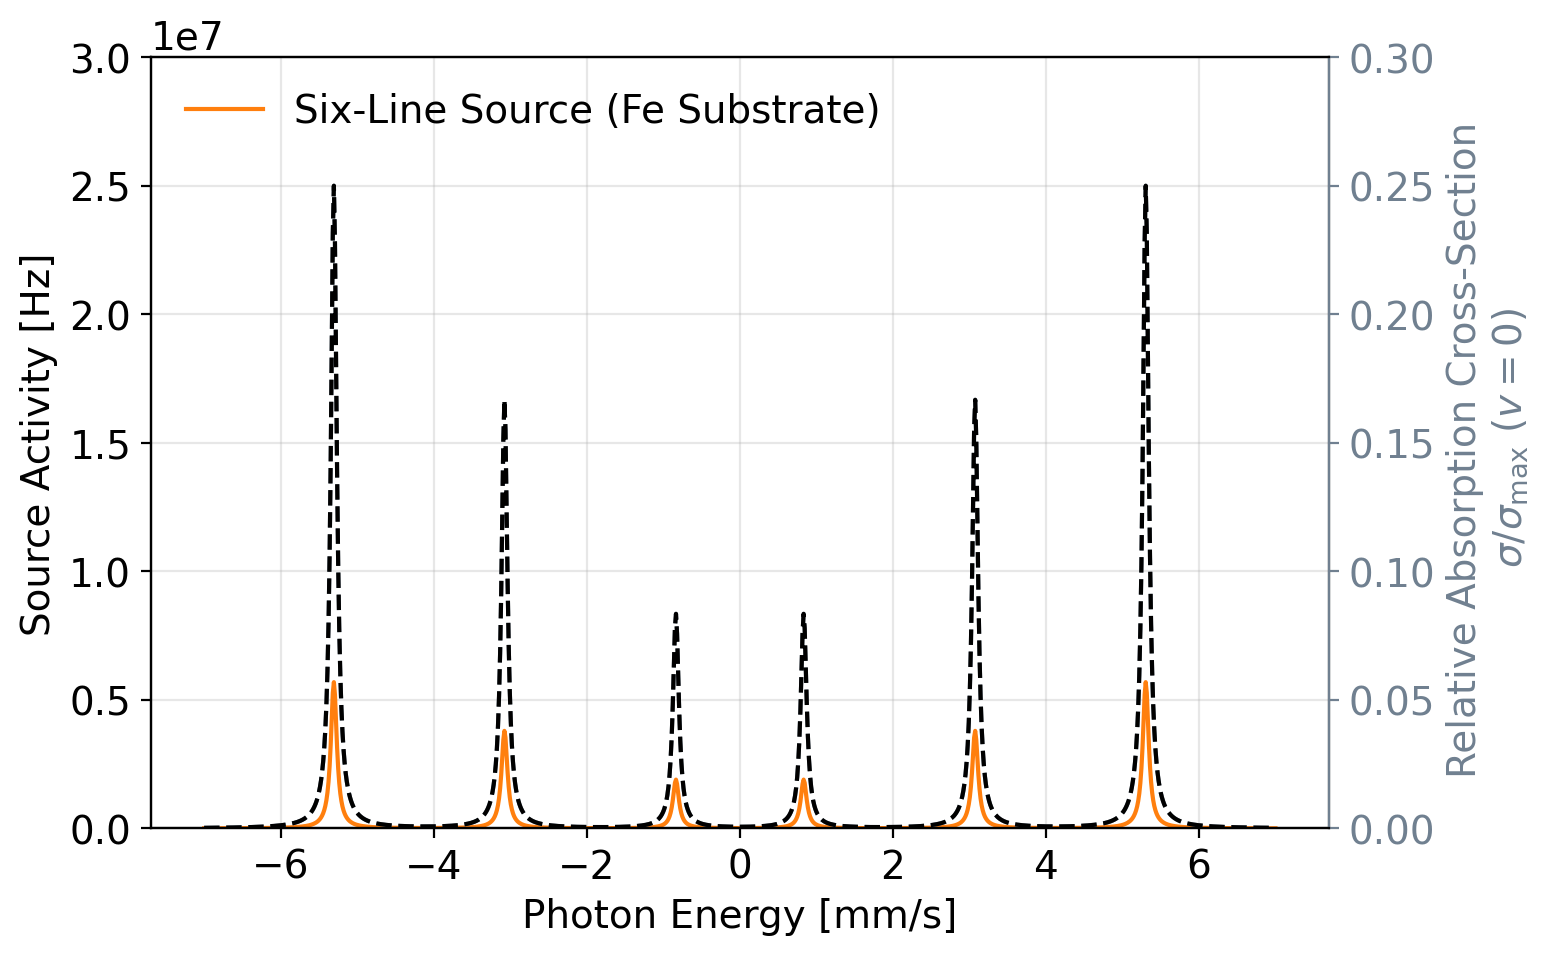

In [12]:
fig, ax = plt.subplots()
#plt.plot(vel, moss_unsplit_source.source.spectrum(vel), label='Single-Line Source (Rh Substrate)')
plt.plot(vel, moss.source.spectrum(vel), label='Six-Line Source (Fe Substrate)',color= 'C1')
plt.ylim([0, 3e7])
plt.xlabel('Photon Energy [mm/s]')
plt.ylabel('Source Activity [Hz]')
ax2 = ax.twinx()
plt.plot(vel, moss_unsplit_source.absorber.cross_section(vel), linestyle='--', color='slategray')
plt.plot(vel, moss.absorber.cross_section(vel), linestyle='--', color='k')
ax2.grid(False)
ax.legend(loc='upper left')
change_axis_color(ax2, 'slategray')
plt.ylim([0, 0.3])
plt.ylabel('Relative Absorption Cross-Section \n $\sigma / \sigma_\mathrm{max}\ (v = 0)$')
plt.tight_layout()
#if True:
#    plt.savefig('plots/spectrum_xsec_overly_0vel.png')
#plt.show()

NameError: name 'nframes' is not defined

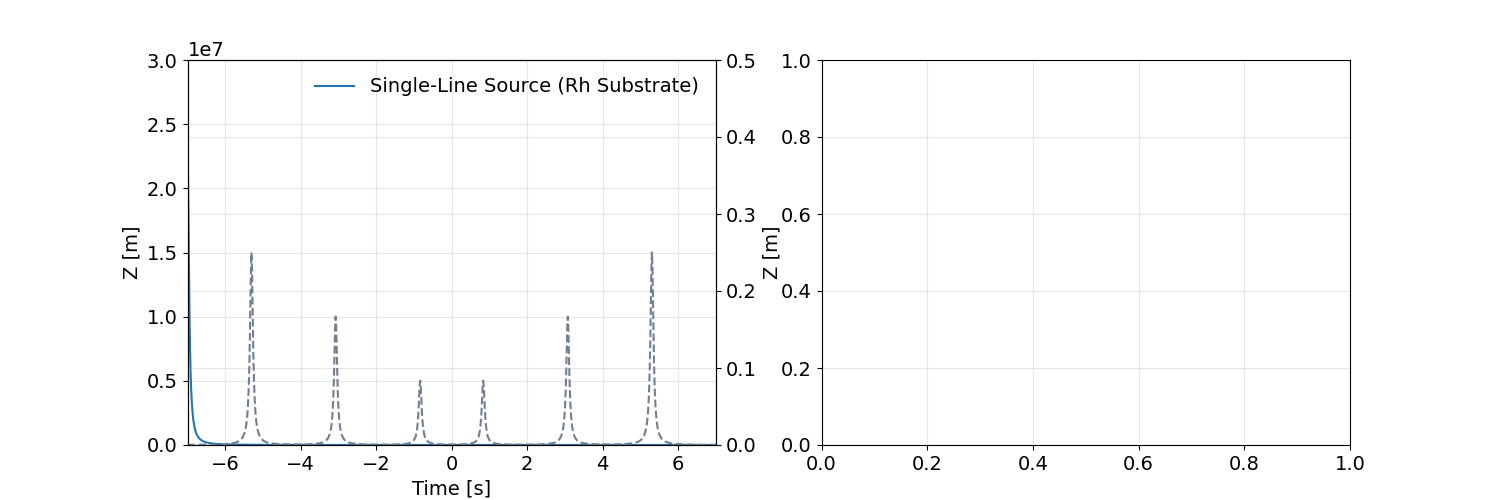

In [154]:
import matplotlib.animation as FuncAnimation

frames = 100

Eres_list = np.linspace(-7,7,frames)
source_line = []
source_parameters_scan = source_parameters

for Eres in Eres_list:    
    source_parameters_scan['Eres'] = Eres
    moss_cross = mossbauer.MossbauerMeasurement(
        source_parameters_scan,
        absorber_parameters,
        measurement_parameters)
    source_line.append(moss_cross.source.spectrum(vel))



fig, ax = plt.subplots(1,1,figsize=(15,5))
ax2 = ax.twinx()

line_source = ax[.plot(vel, source_line[0], label='Single-Line Source (Rh Substrate)')
line_abs = ax2.plot(vel, moss_unsplit_source.absorber.cross_section(vel), linestyle='--', color='slategray')

ax[0].set(xlim=[-7, 7], ylim=[0, 3e7], xlabel='Time [s]', ylabel='Z [m]')
ax2.set(xlim=[-7, 7], ylim=[0, 0.5], xlabel='Time [s]', ylabel='Z [m]')
ax[0].legend(frameon=False)


frames = []



for i in range(nframes):
    
    frame = ax.plot(x, source_line[i],label='Single-Line Source (Rh Substrate)')
    
    frames.append(frame)


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()


#ani.save(filename="example.gif", writer="pillow")

In [ ]:

import matplotlib.animation as animation  
import matplotlib.pyplot as plt  
import numpy as np  
  
   
# creating a blank window 
# for the animation  
fig = plt.figure()  
axis = plt.axes(xlim =(-50, 50), 
                ylim =(-50, 50))  
  
line, = axis.plot([], [], lw = 2)  
   
# what will our line dataset 
# contain? 
def init():  
    line.set_data([], [])  
    return line,  
   
# initializing empty values 
# for x and y co-ordinates 
xdata, ydata = [], []  
   
# animation function  
def animate(i):  
    # t is a parameter which varies 
    # with the frame number 
    t = 0.1 * i  
       
    # x, y values to be plotted  
    x = t * np.sin(t)  
    y = t * np.cos(t)  
       
    # appending values to the previously  
    # empty x and y data holders  
    xdata.append(x)  
    ydata.append(y)  
    line.set_data(xdata, ydata)  
      
    return line, 
   
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = 500, interval = 20, blit = True)  
   
# saves the animation in our desktop 
anim.save('new.gif', writer = "pillow") 


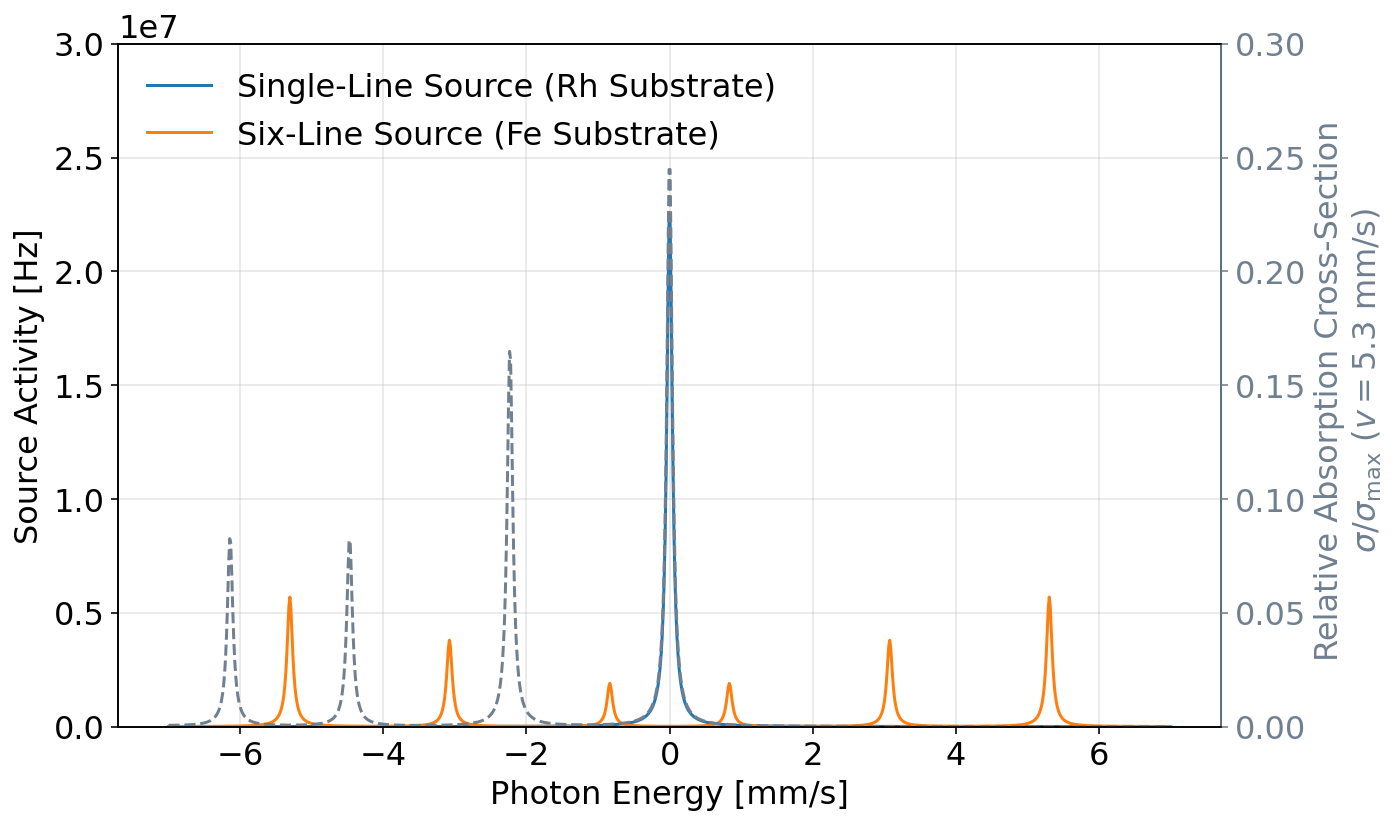

In [151]:
fig, ax = plt.subplots()
plt.plot(vel, moss_unsplit_source.source.spectrum(vel), label='Single-Line Source (Rh Substrate)')
plt.plot(vel, moss.source.spectrum(vel), label='Six-Line Source (Fe Substrate)')
plt.ylim([0, 3e7])
plt.xlabel('Photon Energy [mm/s]')
plt.ylabel('Source Activity [Hz]')
ax2 = ax.twinx()
plt.plot(vel, moss_unsplit_source.absorber.cross_section(vel, pos[-1]), linestyle='--', color='slategray')
ax2.grid(False)
ax.legend(loc='upper left')
change_axis_color(ax2, 'slategray')
plt.ylim([0, 0.3])
plt.ylabel('Relative Absorption Cross-Section \n $\sigma / \sigma_\mathrm{max}\ (v = %.1f\ \mathrm{mm/s})$' % pos[-1])
plt.tight_layout()
if True:
    plt.savefig('plots/spectrum_xsec_overly_maxvel.png')
plt.show()

In [158]:
print('Rh v=0 sum', 'Fe v=5 sum')
print(
    '%.2e' % np.sum(moss_unsplit_source.source.spectrum(vel)*moss_unsplit_source.absorber.cross_section(vel, pos[-1])),
    '%.2e' % np.sum(moss.source.spectrum(vel)*moss_unsplit_source.absorber.cross_section(vel)), 
)

Rh v=0 sum Fe v=5 sum
3.03e+07 2.36e+07


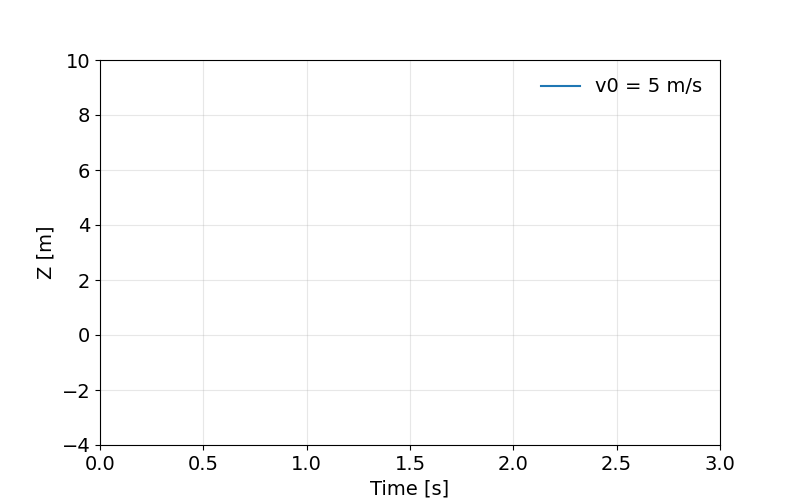

In [132]:
import matplotlib.animation as animation
%matplotlib widget
fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

#scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    #x = t[:frame]
    #y = z[:frame]
    # update the scatter plot:
    #data = np.stack([x, y]).T
    #scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    #print(frame)
    return (line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

ani.save(filename="example.gif", writer="pillow")

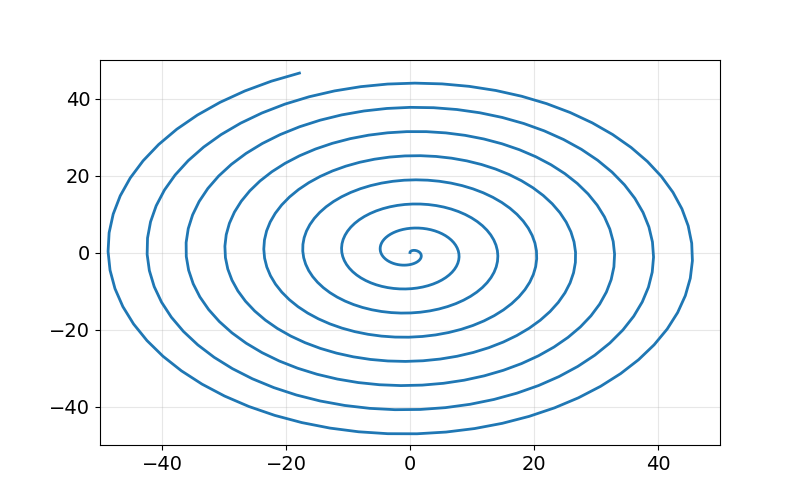

In [155]:

import matplotlib.animation as animation  
import matplotlib.pyplot as plt  
import numpy as np  
  
   
# creating a blank window 
# for the animation  
fig = plt.figure()  
axis = plt.axes(xlim =(-50, 50), 
                ylim =(-50, 50))  
  
line, = axis.plot([], [], lw = 2)  
   
# what will our line dataset 
# contain? 
def init():  
    line.set_data([], [])  
    return line,  
   
# initializing empty values 
# for x and y co-ordinates 
xdata, ydata = [], []  
   
# animation function  
def animate(i):  
    # t is a parameter which varies 
    # with the frame number 
    t = 0.1 * i  
       
    # x, y values to be plotted  
    x = t * np.sin(t)  
    y = t * np.cos(t)  
       
    # appending values to the previously  
    # empty x and y data holders  
    xdata.append(x)  
    ydata.append(y)  
    line.set_data(xdata, ydata)  
      
    return line, 
   
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = 500, interval = 20, blit = True)  
   
# saves the animation in our desktop 
anim.save('growingCoil.gif', writer = "pillow") 
